In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from numpy import quantile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import linear_model
from sklearn.linear_model import SGDOneClassSVM

from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix,f1_score
import missingno as msno  
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, classification_report
import random as rn
import tensorflow as tf
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
import warnings
from datetime import datetime
from sklearn.metrics import confusion_matrix, roc_curve, auc  



In [4]:
# Loading the data
data = pd.read_csv('creditcard.csv')
print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data.head()

Memory usage         67.36 MB
Dataset shape    (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data.shape


(284807, 31)

In [6]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
data.describe().style.set_sticky(axis="index").background_gradient()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,88.349619,0.001727
std,47488.145955,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,1.088850,1.020713,0.999201,0.995274,0.958596,0.915316,0.876253,0.849337,0.838176,0.814041,0.770925,0.734524,0.725702,0.624460,0.605647,0.521278,0.482227,0.403632,0.330083,250.120109,0.041527
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54201.500000,-0.920373,-0.598550,-0.890365,-0.848640,-0.691597,-0.768296,-0.554076,-0.208630,-0.643098,-0.535426,-0.762494,-0.405571,-0.648539,-0.425574,-0.582884,-0.468037,-0.483748,-0.498850,-0.456299,-0.211721,-0.228395,-0.542350,-0.161846,-0.354586,-0.317145,-0.326984,-0.070840,-0.052960,5.600000,0.000000
50%,84692.000000,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,-0.092917,-0.032757,0.140033,-0.013568,0.050601,0.048072,0.066413,-0.065676,-0.003636,0.003735,-0.062481,-0.029450,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,22.000000,0.000000
75%,139320.500000,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,0.453923,0.739593,0.618238,0.662505,0.493150,0.648821,0.523296,0.399675,0.500807,0.458949,0.133041,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.078280,77.165000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


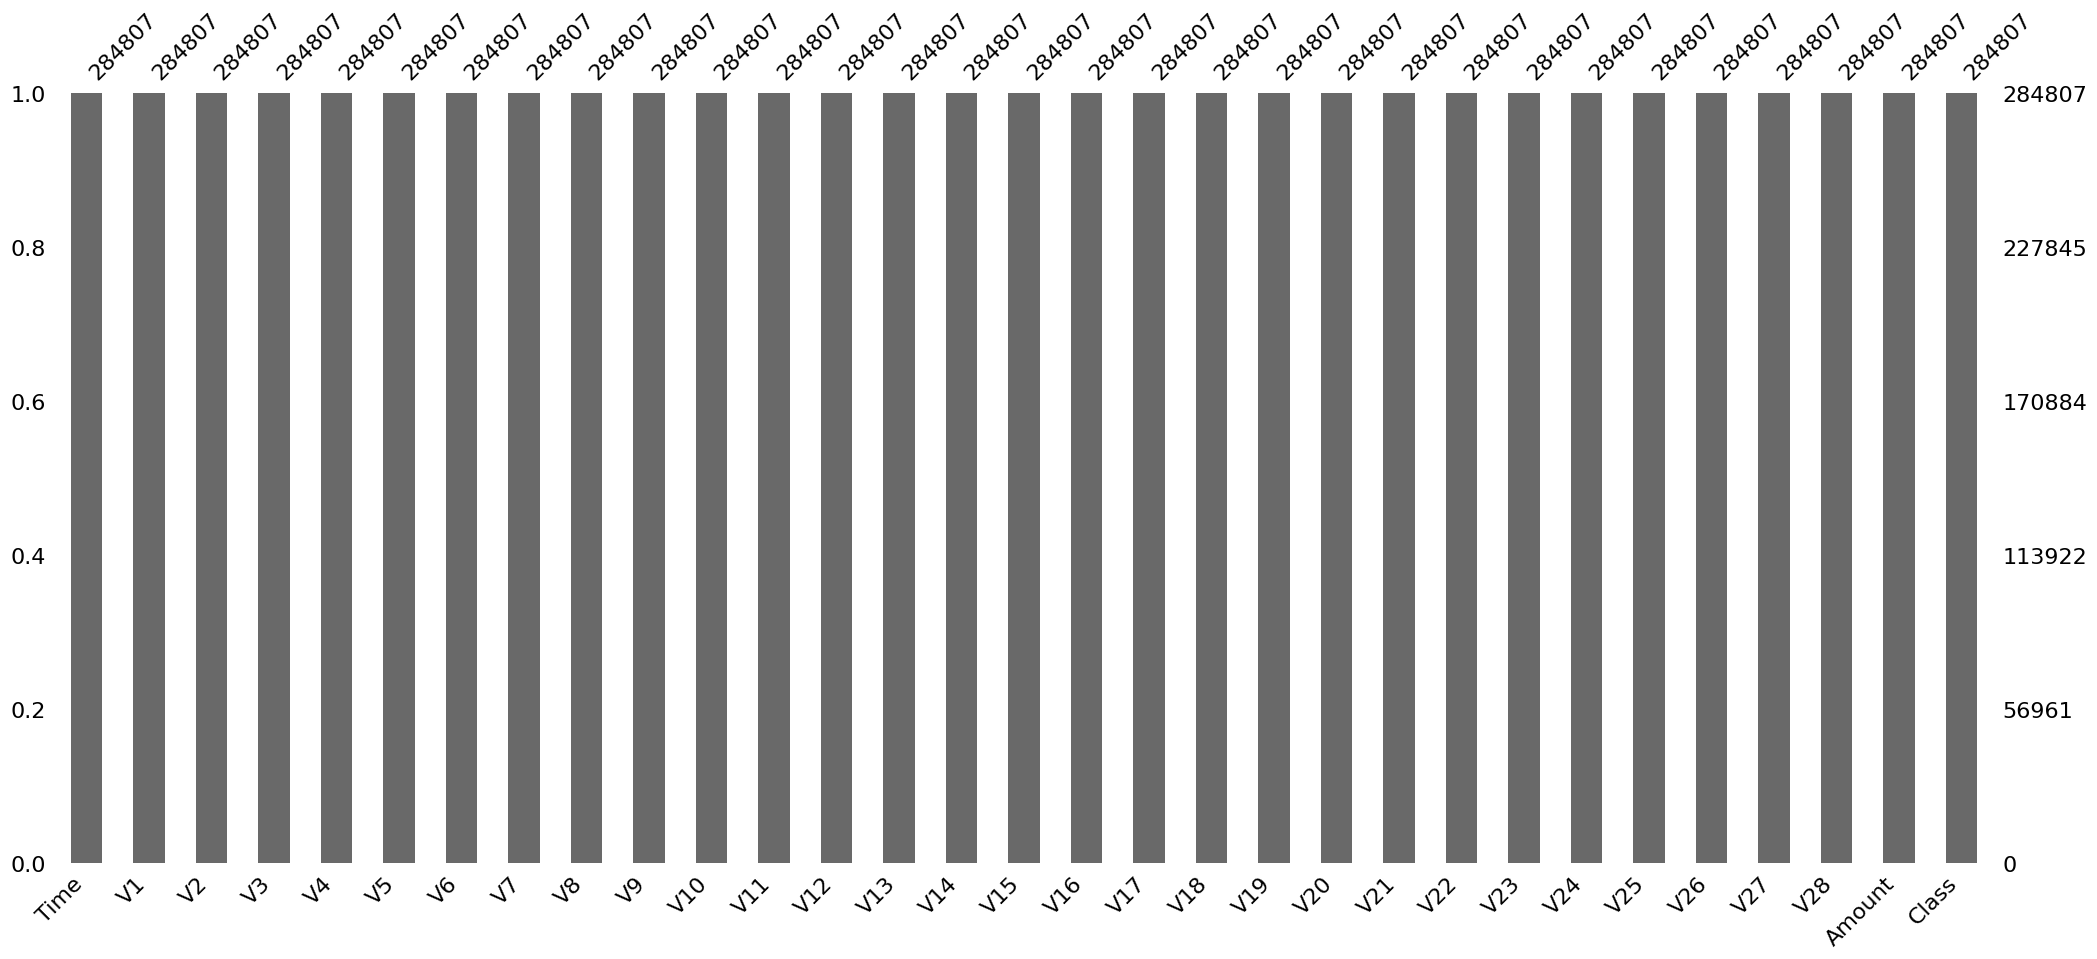

In [9]:
msno.bar(data)  
plt.show()  

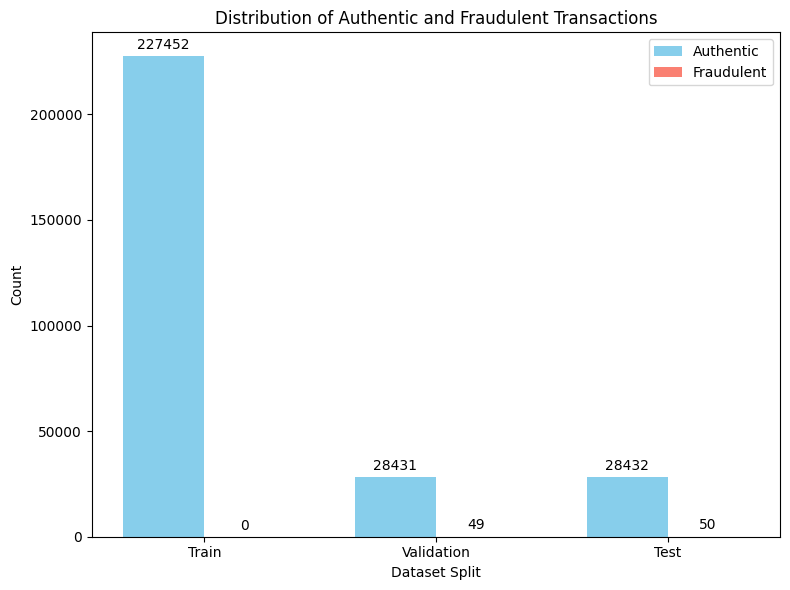

Training set size (authentic): 227452
Validation set size (authentic + fraudulent): 28480
Test set size (authentic + fraudulent): 28482


In [10]:
def split_data_by_class(data, class_label):
    # Filter data by class
    class_data = data[data['Class'] == class_label]
    X, y = class_data.drop('Class', axis=1), class_data['Class']
    
    # Split into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=40)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=40)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Splitting the data for both authentic (Class = 0) and fraudulent (Class = 1) transactions
X_train_auth, X_val_auth, X_test_auth, y_train_auth, y_val_auth, y_test_auth = split_data_by_class(data, 0)
X_train_fraud, X_val_fraud, X_test_fraud, y_train_fraud, y_val_fraud, y_test_fraud = split_data_by_class(data, 1)

# Merging the validation and test sets for both classes
X_val = pd.concat([X_val_auth, X_val_fraud], axis=0)
y_val = pd.concat([y_val_auth, y_val_fraud], axis=0)
X_test = pd.concat([X_test_auth, X_test_fraud], axis=0)
y_test = pd.concat([y_test_auth, y_test_fraud], axis=0)
# Data for the bar chart
labels = ['Train', 'Validation', 'Test']
authentic_counts = [
    len(y_train_auth[y_train_auth == 0]),
    len(y_val[y_val == 0]),
    len(y_test[y_test == 0])
]
fraudulent_counts = [
    len(y_train_auth[y_train_auth == 1]),
    len(y_val[y_val == 1]),
    len(y_test[y_test == 1])
]

# Setting up bar chart positions
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Creating the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, authentic_counts, width, label='Authentic', color='skyblue')
bars2 = ax.bar(x + width/2, fraudulent_counts, width, label='Fraudulent', color='salmon')

# Adding titles and labels
ax.set_xlabel('Dataset Split')
ax.set_ylabel('Count')
ax.set_title('Distribution of Authentic and Fraudulent Transactions')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding value annotations on the bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Display the bar chart
plt.tight_layout()
plt.show()

# Output results for verification
print(f"Training set size (authentic): {X_train_auth.shape[0]}")
print(f"Validation set size (authentic + fraudulent): {X_val.shape[0]}")
print(f"Test set size (authentic + fraudulent): {X_test.shape[0]}")

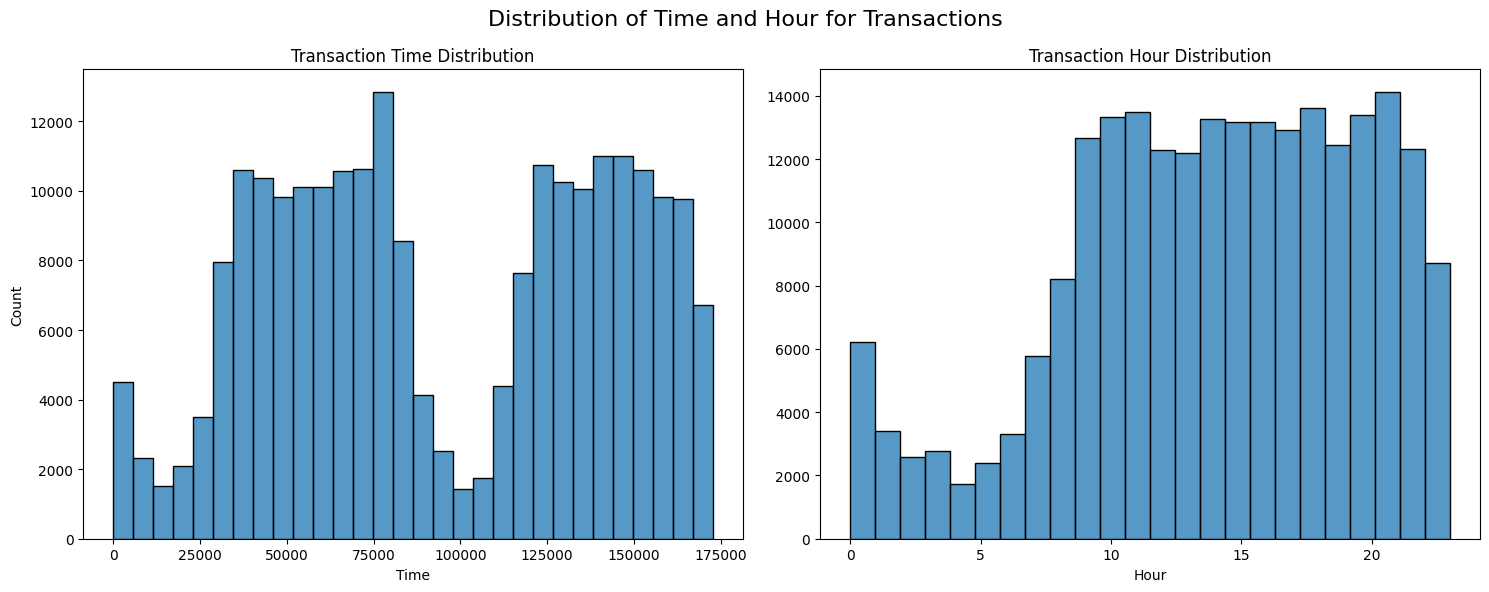

In [11]:
# Decompose 'Time' into Day, Hour, Minute, and Second

def decompose_time(data):
    # Calculate day, hour, minute, and second components
    data['Day'], temp = divmod(data['Time'], 24*60*60)
    data['Hour'], temp = divmod(temp, 60*60)
    data['Minute'], data['Second'] = divmod(temp, 60)

# Apply decomposition to the datasets (use appropriate variables from your split data)
decompose_time(X_train_auth)
decompose_time(X_val)
decompose_time(X_test)

# Preview the decomposition of the 'Time' column in the training dataset
X_train_auth[['Time', 'Day', 'Hour', 'Minute', 'Second']].head()

# Plotting: Histograms of 'Time' and 'Hour'
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

# Histogram for 'Time' feature
sns.histplot(data=X_train_auth, x='Time', bins=30, ax=ax[0])
ax[0].set_title("Transaction Time Distribution")
# Histogram for 'Hour' feature
sns.histplot(data=X_train_auth, x='Hour', bins=24, ax=ax[1])
ax[1].set_title("Transaction Hour Distribution")
ax[1].set_ylabel("")  # Remove the redundant ylabel for the second plot

# Adjust the layout and show the plot
plt.suptitle("Distribution of Time and Hour for Transactions", size=16)
plt.tight_layout()
plt.show()

In [12]:
# Discarding unnecessary columns from training, validation, and test sets
for data in [X_train_auth, X_val, X_test]:
    data.drop(['Time', 'Day', 'Minute', 'Second', 'Amount'], axis=1, inplace=True)

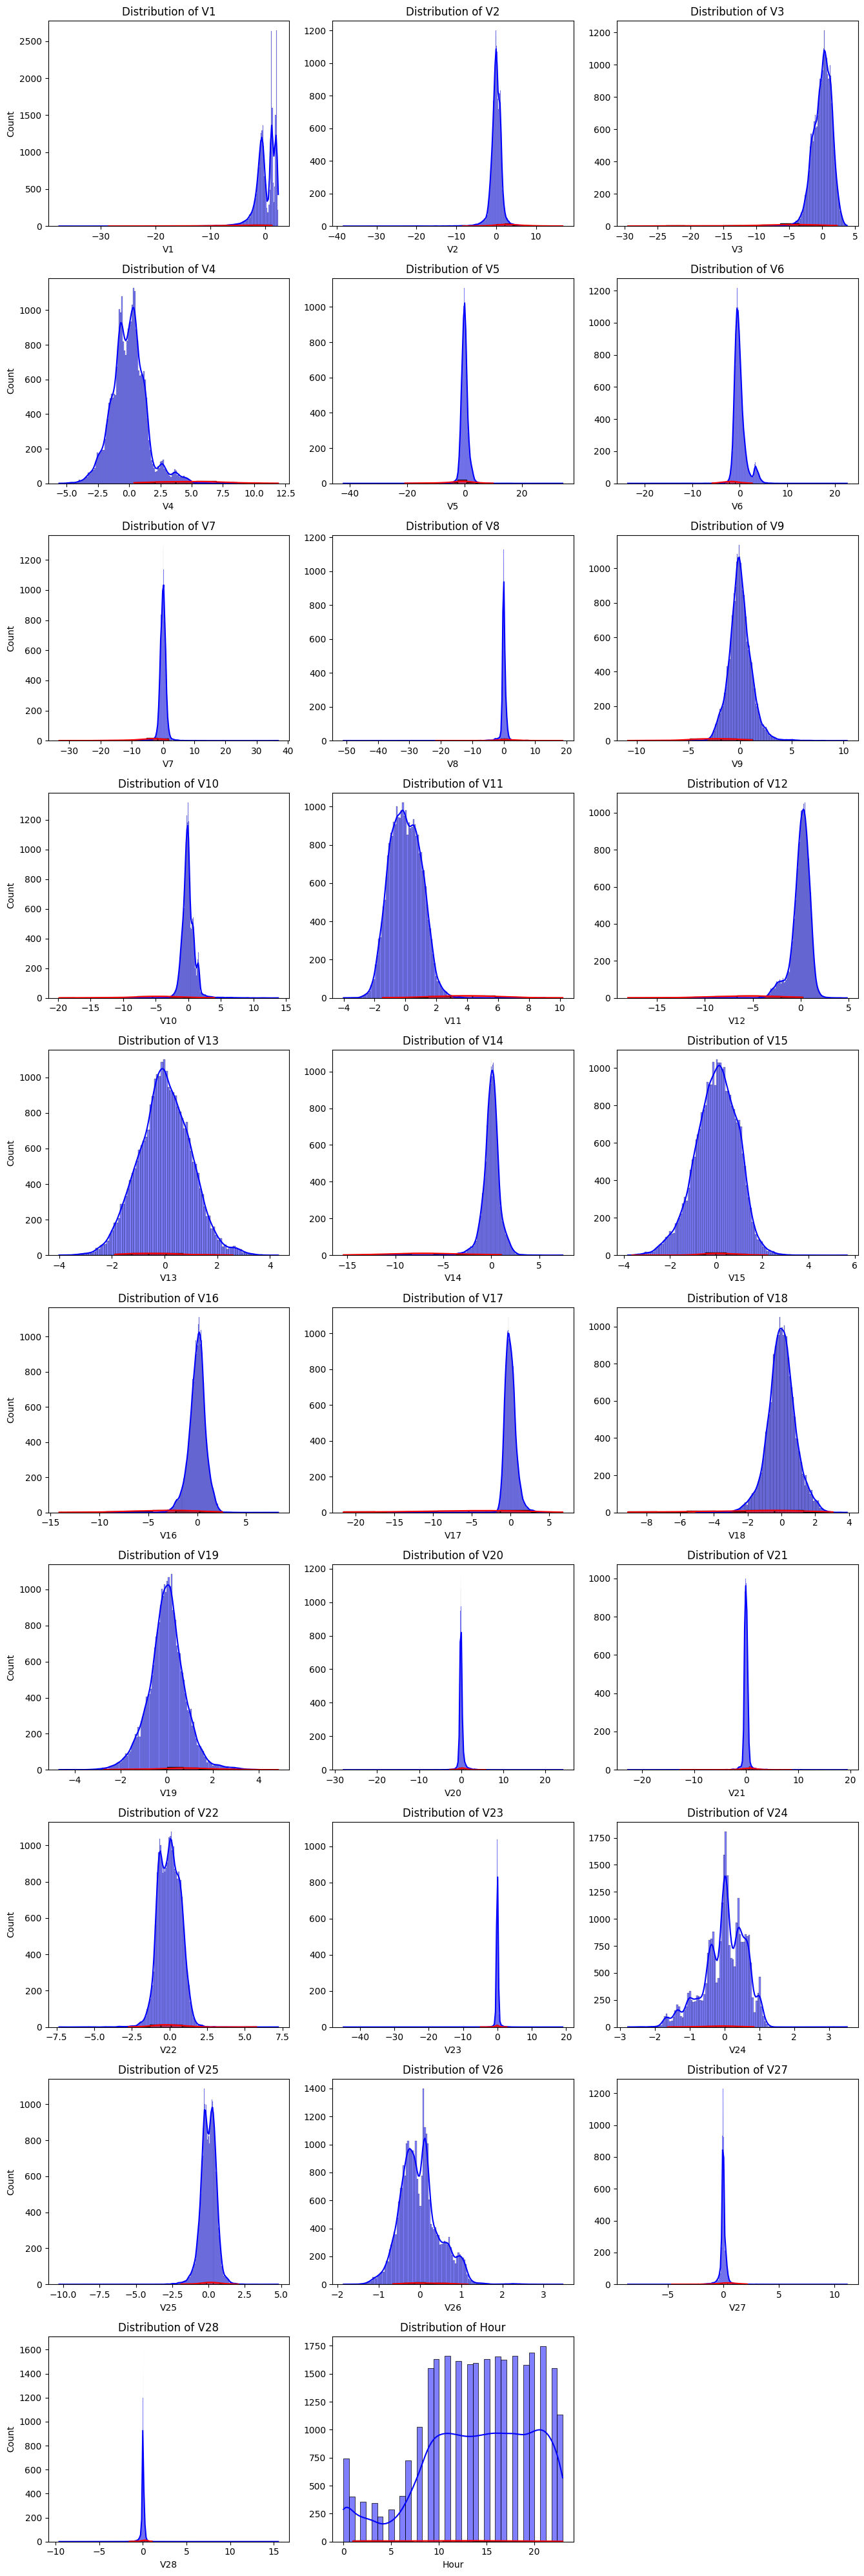

In [13]:
# Suppress specific FutureWarning related to Seaborn
warnings.simplefilter(action='ignore', category=FutureWarning)
# Concatenate validation data with target labels (Class)
data_val = pd.concat([X_val, y_val], axis=1)

# Split data into authentic (Class = 0) and fraudulent (Class = 1) transactions
authentic_data = data_val[data_val['Class'] == 0]
fraudulent_data = data_val[data_val['Class'] == 1]

# List of feature columns to plot
feature_columns = list(X_val.columns)

# Calculate number of rows and columns for the subplots grid
ncols = 3
nrows = math.ceil(len(feature_columns) / ncols)

# Create the subplots
fig, ax = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 4 * nrows))

# Flatten the axes array for easier indexing (to handle multi-row, multi-column)
ax = ax.flatten()
# Loop through each feature column to plot KDE for both classes
for i, feature in enumerate(feature_columns):
    sns.histplot(authentic_data[feature], ax=ax[i], kde=True, label='Authentic', color='blue')
    sns.histplot(fraudulent_data[feature], ax=ax[i], kde=True, label='Fraudulent', color='red')
    
    # Set titles and remove redundant y-axis labels
    ax[i].set_title(f'Distribution of {feature}')
    if i % ncols != 0:
        ax[i].set_ylabel('')

# Remove empty subplots if any (if there are more subplots than features)
for i in range(len(feature_columns), len(ax)):
    fig.delaxes(ax[i])

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


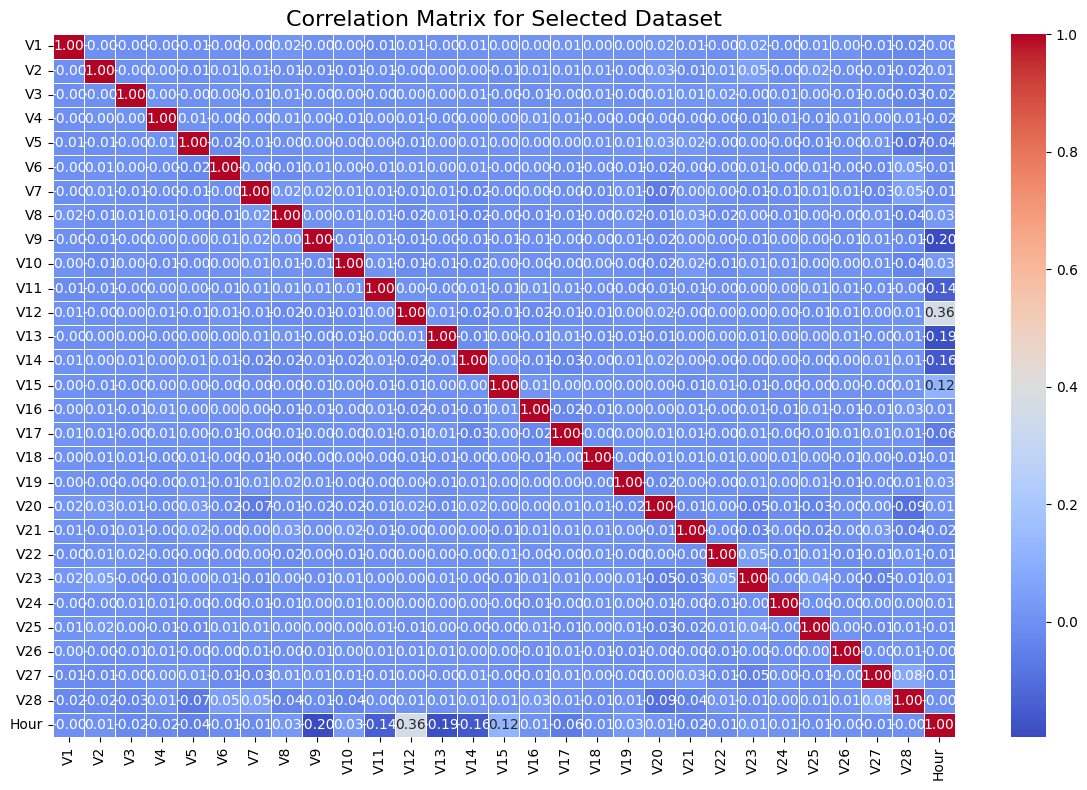

In [14]:
# Select the dataset you want to plot the correlation matrix for (X_train, X_val, X_test)
data_to_plot = X_val  

# Compute the correlation matrix
correlation_matrix = data_to_plot.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix for Selected Dataset", size=16)
plt.tight_layout()
plt.show()

In [15]:
# Get all the columns from the X_val dataframe
columns = X_val.columns.tolist()

# Filter the columns to remove 'Class' as it is not part of the features
columns = [c for c in columns if c not in ["Class"]]

# Store the variable we are predicting (Target column)
target = "Class"
X = X_val[columns]  # Use X_val for outlier detection
Y = y_val  # Use the corresponding target (y_val)

# Define a random state for reproducibility
state = np.random.RandomState(42)

# Initialize classifiers for outlier detection
classifiers = {
    "Isolation Forest": IsolationForest(n_estimators=100, max_samples='auto', 
                                       contamination=0.05, random_state=state, verbose=0),
    "Local Outlier Factor": LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=0.05),
    "Support Vector Machine": OneClassSVM(kernel='rbf', degree=3, gamma=0.1, nu=0.05, 
                                         max_iter=-1)  # No random_state here
}

# Run each classifier and evaluate performance
for clf_name, clf in classifiers.items():
    # Ensure we pass data with feature names (DataFrame, not NumPy array)
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)  # Predictions are -1 (outlier) and 1 (inlier)
        scores_prediction = clf.negative_outlier_factor_  # Score for each point
        
    elif clf_name == "Support Vector Machine":
        clf.fit(X)  # Fit the model
        y_pred = clf.predict(X)  # Prediction: 1 for normal, -1 for outlier
    else:    
        clf.fit(X)  # Fit the Isolation Forest model
        scores_prediction = clf.decision_function(X)  # Get decision function values
        y_pred = clf.predict(X)  # 1 for normal, -1 for outlier
    
    # Reshape predictions (convert to 0 for normal and 1 for outlier)
    y_pred[y_pred == 1] = 0  # Normal transactions = 0
    y_pred[y_pred == -1] = 1  # Outliers = 1
    
    # Calculate the number of errors (where prediction differs from actual label)
    n_errors = (y_pred != Y).sum()
    
    # Display the metrics
    print(f"{clf_name}: {n_errors} errors")
    print("Accuracy Score:")
    print(accuracy_score(Y, y_pred))
    print("Classification Report:")
    print(classification_report(Y, y_pred))

Isolation Forest: 1385 errors
Accuracy Score:
0.9513693820224719
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     28431
           1       0.03      0.90      0.06        49

    accuracy                           0.95     28480
   macro avg       0.52      0.92      0.52     28480
weighted avg       1.00      0.95      0.97     28480

Local Outlier Factor: 1417 errors
Accuracy Score:
0.950245786516854
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     28431
           1       0.02      0.57      0.04        49

    accuracy                           0.95     28480
   macro avg       0.51      0.76      0.51     28480
weighted avg       1.00      0.95      0.97     28480

Support Vector Machine: 2450 errors
Accuracy Score:
0.9139747191011236
Classification Report:
              precision    recall  f1-score   support

           0      

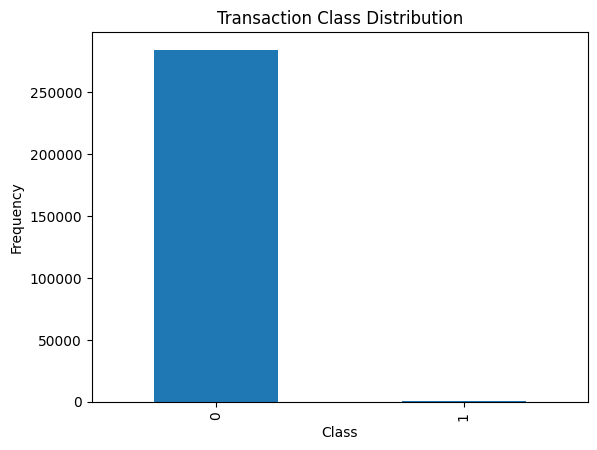

Total Number of Frauds: 492
Total Number of Normal Transactions: 284315


In [16]:
# Load the data
data = pd.read_csv('creditcard.csv')

# Count and visualize transaction classes
count_classes = data['Class'].value_counts()
count_classes.plot(kind='bar', title="Transaction Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

# Calculate and display the number of fraud and normal transactions
fraud_count = count_classes.get(1, 0)
normal_count = count_classes.get(0, 0)

print(f"Total Number of Frauds: {fraud_count}")
print(f"Total Number of Normal Transactions: {normal_count}")

In [17]:
# manual parameters
RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [18]:
# let's quickly convert the columns to lower case and rename the Class column 
# so as to not cause syntax errors
data.columns = map(str.lower, data.columns)
data.rename(columns={'class': 'label'}, inplace=True)

# print first 5 rows to get an initial impression of the data we're dealing with
data.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [19]:
# Calculate the number of fraud cases
fraud_count = data[data['label'] == 1].shape[0]

# Calculate the total number of transactions
total_count = data.shape[0]

# Calculate the percentage of fraud cases
fraud_percentage = (fraud_count / total_count) * 100

# Print the result
print(f"Percentage of Fraud Cases: {fraud_percentage:.2f}%")

Percentage of Fraud Cases: 0.17%


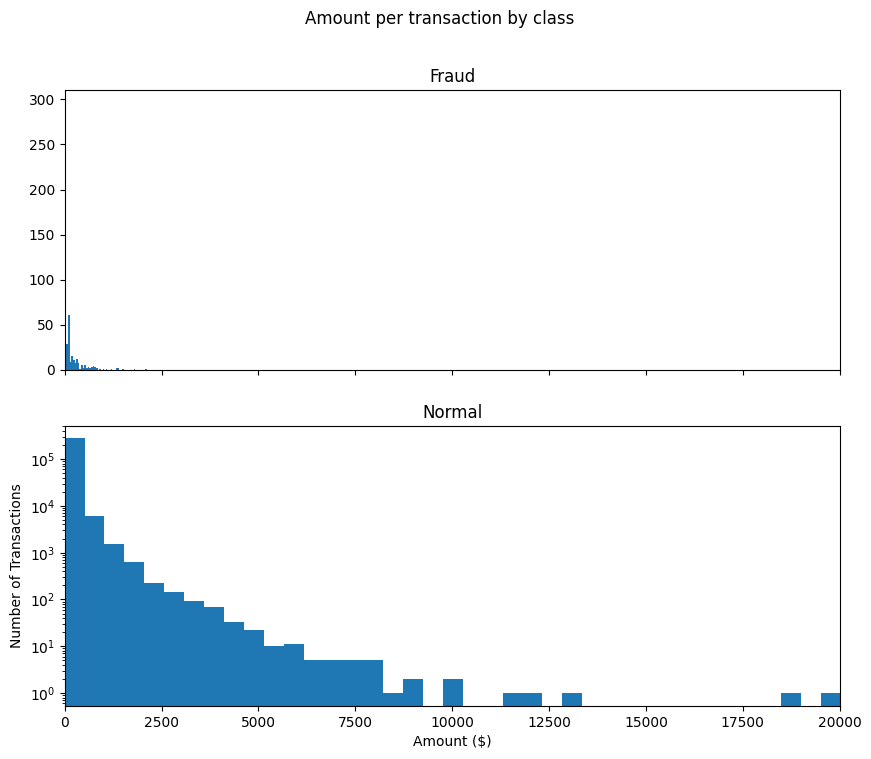

In [20]:
# Separate the data into fraud and normal transactions
fraud = data[data['label'] == 1]
normal = data[data['label'] == 0]
# add a negligible amount to avoid taking the log of 0
data['log10_amount'] = np.log10(data.amount + 0.00001)
# Create subplots
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
f.suptitle('Amount per transaction by class')

# Number of bins for histograms
bins = 50

# Plot histograms for fraud transactions
ax1.hist(fraud['amount'], bins=bins)
ax1.set_title('Fraud')

# Plot histograms for normal transactions
ax2.hist(normal['amount'], bins=bins)
ax2.set_title('Normal')

# Set labels and axis properties
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))  # Set x-axis limits for better visualization
plt.yscale('log')  # Use log scale for y-axis

# Show the plot
plt.show()


In [21]:
# keep the label field at the back
data = data[
    [col for col in data if col not in ['label', 'log10_amount']] + 
    ['log10_amount', 'label']
]

In [22]:
# Define the ratio of clean to fraud transactions for undersampling
RATIO_TO_FRAUD = 15

# Drop redundant columns that are not needed for the analysis
data = data.drop(['time', 'amount'], axis=1)

# Split the dataset into fraud and clean transactions based on the label
fraud = data[data.label == 1]  # Transactions labeled as fraud.label == 1]  # Transactions labeled as fraud
clean = data[data.label == 0]  # Transactions labeled as clean

# Perform undersampling on clean transactions to balance the dataset
clean_undersampled = clean.sample(
    n=int(len(fraud) * RATIO_TO_FRAUD),  # Maintain the specified fraud-to-clean ratio
    random_state=RANDOM_SEED  # Ensure reproducibility
)

# Combine the undersampled clean transactions with all fraud transactions
visualisation_initial = pd.concat([fraud, clean_undersampled])

# Extract the column names of the features (excluding the label column)
column_names = list(visualisation_initial.drop('label', axis=1).columns)

# Separate features (X) and labels (y) for model input
features = visualisation_initial.drop('label', axis=1).values  # Feature matrix
labels = visualisation_initial.label.values  # Target labels

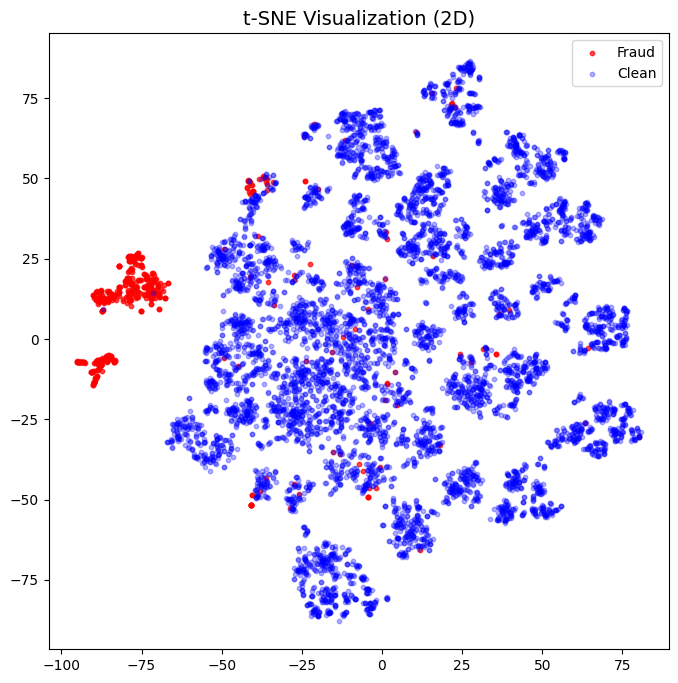

In [23]:
def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
    """
    Visualize high-dimensional data using t-SNE with support for 2D and 3D plots.

    Args:
        features (np.ndarray): High-dimensional feature matrix.
        labels (np.ndarray): Corresponding labels for the data points.
        dimensions (int): Number of dimensions for visualization (2 or 3).
        save_as (str): File name to save the plot.

    Raises:
        ValueError: If dimensions is not 2 or 3.
    """
    # Validate the dimensions parameter
    if dimensions not in (2, 3):
        raise ValueError("tsne_scatter can only plot in 2D or 3D. "
            "Make sure the 'dimensions' argument is either 2 or 3."
        )

    # Apply t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)

    # Initialize the plot
    fig = plt.figure(figsize=(8, 8))
    if dimensions == 3:
        ax = fig.add_subplot(111, projection='3d')  # 3D plot
    else:
        ax = fig.add_subplot(111)  # 2D plot

    # Scatter plot for fraudulent transactions
    ax.scatter(
        *zip(*features_embedded[labels == 1]),  # Fraud points
        marker='o',
        color='red',
        s=10,
        alpha=0.7,
        label='Fraud'
    )

    # Scatter plot for clean transactions
    ax.scatter(
        *zip(*features_embedded[labels == 0]),  # Clean points
        marker='o',
        color='blue',
        s=10,
        alpha=0.3,
        label='Clean'
    )

    # Add legend and title
    ax.legend(loc='best')
    plt.title(f't-SNE Visualization ({dimensions}D)', fontsize=14)

    # Save and display the plot
    plt.savefig(save_as)
    plt.show()

# Call the function with example parameters
tsne_scatter(features, labels, dimensions=2, save_as='tsne_initial_2d.png')

In [24]:
print(f"""Shape of the datasets:
    clean (rows, cols) = {clean.shape}
    fraud (rows, cols) = {fraud.shape}""")

Shape of the datasets:
    clean (rows, cols) = (284315, 30)
    fraud (rows, cols) = (492, 30)


In [25]:
# Shuffle the clean (non-fraud) transactions for randomness
clean = clean.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

# Create the training set: exclusively non-fraud transactions
X_train = clean.iloc[:TRAINING_SAMPLE].drop('label', axis=1)

# Create the testing set: remaining non-fraud transactions + all fraud transactions
X_test = pd.concat([clean.iloc[TRAINING_SAMPLE:], fraud]).sample(frac=1, random_state=RANDOM_SEED)

In [26]:
# Split the training data into training and validation sets (no labels needed for validation since the data is clean)
X_train, X_validate = train_test_split(
    X_train, 
    test_size=VALIDATE_SIZE, 
    random_state=RANDOM_SEED
)

# Separate features and labels in the test set (before converting to numpy arrays)
y_test = X_test['label'].values  # Extract labels for the test set
X_test = X_test.drop('label', axis=1)  # Drop the 'label' column from features

# Convert features to numpy arrays after dropping the label
X_test = X_test.values

# Print the shape of each dataset to verify the splits
print(f"""Shape of the datasets:
    Training set (rows, cols) = {X_train.shape}
    Validation set (rows, cols) = {X_validate.shape}
    Test set (rows, cols) = {X_test.shape}""")


Shape of the datasets:
    Training set (rows, cols) = (160000, 29)
    Validation set (rows, cols) = (40000, 29)
    Test set (rows, cols) = (84807, 29)


In [27]:
# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

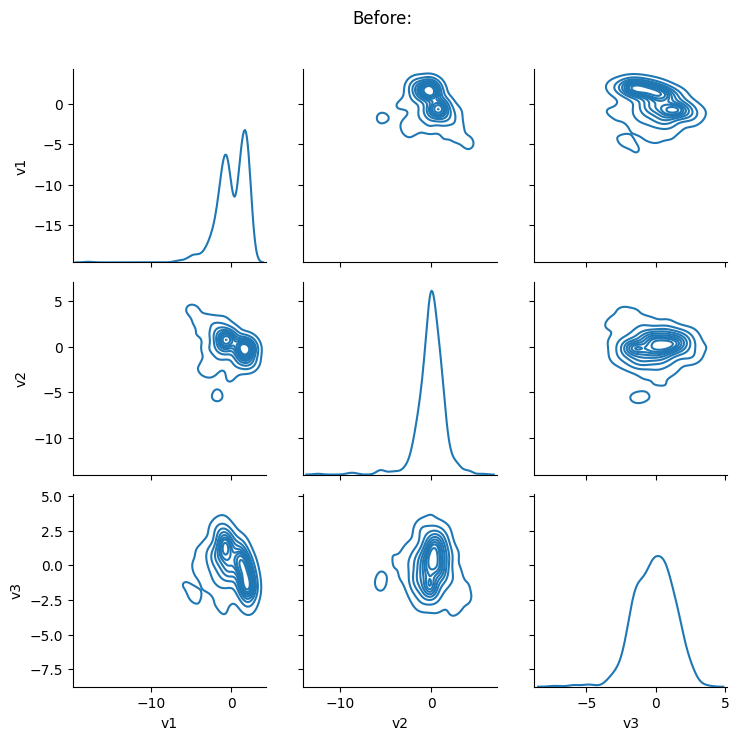

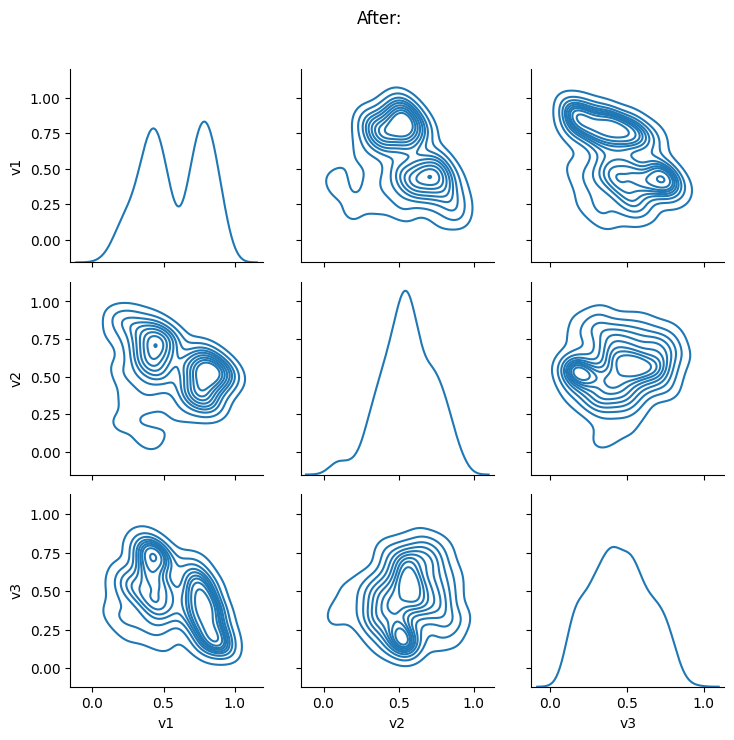

In [28]:
# Suppress specific FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Fitting the pipeline to the training data to acquire normalization parameters
pipeline.fit(X_train)

# Applying the transformations using the parameters acquired from the training data
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

# Convert the transformed data (which is a NumPy array) back to a Pandas DataFrame
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=X_train.columns)

# Create a pair grid for the original data (Before transformation)
g_before = sns.PairGrid(X_train.iloc[:, :3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g_before.fig.suptitle('Before:')
g_before.map_diag(sns.kdeplot)
g_before.map_offdiag(sns.kdeplot)

# Create a pair grid for the transformed data (After transformation)
g_after = sns.PairGrid(X_train_transformed_df.iloc[:, :3].sample(600, random_state=RANDOM_SEED))
plt.subplots_adjust(top=0.9)
g_after.fig.suptitle('After:')
g_after.map_diag(sns.kdeplot)
g_after.map_offdiag(sns.kdeplot)

plt.show()

In [29]:
# Data dimensions and hyperparameters
input_dim = X_train_transformed.shape[1]  # Number of features in the training data
BATCH_SIZE = 256  # Number of samples per gradient update
EPOCHS = 100  # Number of training epochs

# Building the Autoencoder model
autoencoder = tf.keras.models.Sequential([

    # Encoder: Compress input data to lower dimensions
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )),  # Input layer
    tf.keras.layers.Dense(16, activation='elu'),  # Hidden layer with 16 units
    tf.keras.layers.Dense(8, activation='elu'),   # Hidden layer with 8 units
    tf.keras.layers.Dense(4, activation='elu'),   # Hidden layer with 4 units
    tf.keras.layers.Dense(2, activation='elu'),   # Bottleneck layer (lowest dimensional representation)
        
    # Decoder: Reconstruct the data back to the original dimensions
    tf.keras.layers.Dense(4, activation='elu'),   # Expanding back with 4 units
    tf.keras.layers.Dense(8, activation='elu'),   # Expanding back with 8 units
    tf.keras.layers.Dense(16, activation='elu'),  # Expanding back with 16 units
    tf.keras.layers.Dense(input_dim, activation='elu')  # Output layer to match the input dimension
    
])

# Compile the autoencoder model
autoencoder.compile(optimizer="adam",  # Adam optimizer for efficient training
                    loss="mse",  # Mean Squared Error as the loss function
                    metrics=["acc"])  # Accuracy metric to evaluate performance

autoencoder.summary()


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 29)             │           870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 29)             │           493 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,221 (8.68 KB)

 Trainable params: 2,221 (8.68 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Get the current date and time in 'yyyymmddHHMM' format
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# Create a new directory name for this run based on current time, batch size, and number of layers in the model
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# Define early stopping to halt training when the validation loss stops improving
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss for early stopping
    min_delta=0.0001,     # Minimum change to qualify as an improvement
    patience=10,          # Number of epochs to wait for improvement before stopping
    verbose=1,            # Print progress messages
    mode='min',           # Stop when validation loss has stopped decreasing
    restore_best_weights=True  # Restore the best model weights when training stops
)
# Define model checkpoint to save the best model weights during training
save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.keras',  # Use .keras extension instead of .hdf5
    save_best_only=True,  # Save only the best model based on validation loss
    monitor='val_loss',   # Monitor validation loss
    verbose=0,            # Do not print any messages on saving
    mode='min'            # Save the model when validation loss is minimized
)

# Define TensorBoard callback for visualizing training progress
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir=f'logs/{log_subdir}',  # Log directory to store TensorBoard logs
    update_freq='batch'            # Update logs after every batch (you can also set to 'epoch')
)
# List of all the callbacks
callbacks = [early_stop, save_model, tensorboard]

# Train the autoencoder model
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,  # Training data (autoencoder uses input as output)
    shuffle=True,  # Shuffle the data before training
    epochs=EPOCHS,  # Number of training epochs
    batch_size=BATCH_SIZE,  # Batch size for each iteration
    callbacks=callbacks,  # List of callbacks for monitoring and saving the model
    validation_data=(X_validate_transformed, X_validate_transformed)  # Validation data for evaluation during training
)


Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - acc: 0.1690 - loss: 0.0677 - val_acc: 0.2609 - val_loss: 0.0171
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - acc: 0.2575 - loss: 0.0168 - val_acc: 0.2796 - val_loss: 0.0152
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - acc: 0.3149 - loss: 0.0148 - val_acc: 0.3427 - val_loss: 0.0145
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.3408 - loss: 0.0144 - val_acc: 0.3384 - val_loss: 0.0142
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - acc: 0.3386 - loss: 0.0141 - val_acc: 0.3245 - val_loss: 0.0139
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - acc: 0.3276 - loss: 0.0138 - val_acc: 0.3282 - val_loss: 0.0137
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - acc: 0.3338 - loss: 0.0137 - val_acc: 0.3411 - val_loss: 0.0137
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - acc: 0.3480 - loss: 0.0136 - val_acc: 0.3558 - val_loss: 0.0135
Epoch 9/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/

In [31]:
# Transform the test set with the pipeline fitted to the training set
X_test_transformed = pipeline.transform(X_test)

# Pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

# Calculate the mean squared error (MSE) reconstruction loss per row
# mse will be a 1D array where each entry represents the MSE for a single transaction
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


2651/2651 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


In [32]:
# Predicting the reconstructed values using the autoencoder model
predictions = autoencoder.predict(X_test_transformed)

# Calculating the Mean Squared Error (MSE) for each test sample
mse = np.mean(np.power(X_test_transformed - predictions, 2), axis=1)

# Creating a DataFrame to store the reconstruction errors and true class labels
error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test})

# Summarizing the reconstruction errors
error_df.describe()

2651/2651 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


,reconstruction_error,true_class
count,84807.000000,84807.000000
mean,0.009503,0.005801
std,0.004586,0.075946
min,0.001000,0.000000
25%,0.006179,0.000000
50%,0.008595,0.000000
75%,0.012003,0.000000
max,0.045689,1.000000


In [33]:
THRESHOLD = 3

def mad_score(points):
    """Calculate the Modified Z-score using the Median Absolute Deviation (MAD).
    
    Args:
        points (array-like): Array of data points to calculate MAD for.
        
    Returns:
        np.ndarray: The modified Z-scores for the data points.
    """
    # Compute the median of the points
    median = np.median(points)
    
    # Calculate the absolute deviations from the median
    abs_deviation = np.abs(points - median)
    
    # Compute the MAD (Median Absolute Deviation)
    mad = np.median(abs_deviation)
        # Return the Modified Z-scores using the constant 0.6745
    return 0.6745 * abs_deviation / mad

# Calculate the MAD scores for reconstruction errors (mse)
z_scores = mad_score(mse)

# Identify the outliers based on the threshold
outliers = z_scores > THRESHOLD

# Output the results
outliers_count = np.sum(outliers)
total_count = np.size(z_scores)
outliers_percentage = outliers_count / total_count * 100

print(f"Detected {outliers_count:,} outliers in a total of {total_count:,} transactions "
      f"({outliers_percentage:.2f}%).")
    

Detected 1,872 outliers in a total of 84,807 transactions (2.21%).


In [34]:
# Get the confusion matrix for the true labels and predicted outliers
cm = confusion_matrix(y_test, outliers)

# Extract true/false positives and negatives from the confusion matrix
tn, fp, fn, tp = cm.flatten()

# Calculate precision and recall
precision = tp / (fp + tp) if (fp + tp) > 0 else 0  # Avoid division by zero
recall = tp / (fn + tp) if (fn + tp) > 0 else 0  # Avoid division by zero

# Output the classification results
print(f"""
The classifications using the MAD method with threshold={THRESHOLD} are as follows:
Confusion Matrix:
{cm}

- Percentage of transactions labeled as fraud that were correct (Precision): {precision:.2%}
- Percentage of fraudulent transactions successfully detected (Recall): {recall:.2%}
""")


The classifications using the MAD method with threshold=3 are as follows:
Confusion Matrix:
[[82797  1518]
 [  138   354]]

- Percentage of transactions labeled as fraud that were correct (Precision): 18.91%
- Percentage of fraudulent transactions successfully detected (Recall): 71.95%



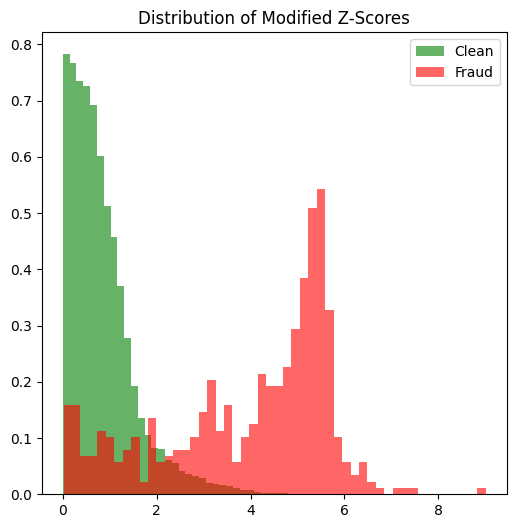

In [35]:
# Separate the z-scores for clean and fraud transactions
clean = z_scores[y_test == 0]
fraud = z_scores[y_test == 1]

# Plotting the distribution of z-scores
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the clean transactions (green)
ax.hist(clean, bins=50, density=True, label="Clean", alpha=0.6, color="green")

# Plot the fraud transactions (red)
ax.hist(fraud, bins=50, density=True, label="Fraud", alpha=0.6, color="red")

# Adding title and legend
plt.title("Distribution of Modified Z-Scores")
plt.legend(loc="best")

# Display the plot
plt.show()

In [36]:
# We're using the first 5 layers of the autoencoder to create a model for dimensionality reduction.
encoder = tf.keras.models.Sequential(autoencoder.layers[:5])
encoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 29)             │           870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,532 (5.98 KB)

 Trainable params: 1,532 (5.98 KB)

 Non-trainable params: 0 (0.00 B)